# __Raw Project__

## Project Content

<a id = 0></a>

### First Step: First Organization

1. [Introduction](#1)
2. [Loading libraries and packages to embark our new journey](#2)
3. [Loading and Checking The Dataset](#3)

### Second Step: Data Preprocessing

4. [Exploratory Data Analysis](#4)
5. [Numeric Fields Analysis](#5)
6. [Categorical Fields Analysis](#6)
7. [Feature Scaling](#7)
8. [Correlation Analysis](#8)
9. [Dealing with Outliers](#9)
10. [Determining Distributions of Numeric Fields](#10)
11. [Appllying One Hot Encoding to Categorical Fields](#11)
12. [Feature Scaling with The RobustScaler Method](#12)
13. [Seperating Data into Two Parts of Train and Test](#13)

### Third and Final Step: Modeling

16. [Modelling (Logistic Regression)](#16)
17. [Cross Validation (Logistic Regression)](#17)
18. [AUC-ROC Curve (Logistic Regression)](#18)
19. [Hyper Parameter Optimization (Logistic Regression)](#19)
20. [Modelling (Decision Tree)](#20)
21. [Cross Validation (Decision Tree)](#21)
22. [AUC-ROC Curve (Decision Tree)](#22)
23. [Hyper Parameter Optimization (Decision Tree)](#23)
24. [Modelling (Support Vector Classifier)](#24)
25. [Cross Validation (Support Vector Classifier)](#25)
26. [AUC-ROC Curve (Support Vector Classifier)](#26)
27. [Hyper Parameter Optimization (Support Vector Classifier)](#27)
24. [Modelling (Random Forest)](#28)
25. [Cross Validation (Support Vector Classifier)](#29)
26. [AUC-ROC Curve (Support Vector Classifier)](#30)
27. [Hyper Parameter Optimization (Support Vector Classifier)](#31)

## 1. Introduction <a id = 1></a>

[Project Content](#0)

## 2. Loading libraries and packages to embark our new journey <a id = 2></a>

In [188]:
# Basic Python Packages

import warnings
warnings.filterwarnings("ignore")

# Numpy Library

import numpy as np

# Pandas Library

import pandas as pd

# Visualization Libraries (Matplotlib, Seaborn, Missingno)

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Sklean Modules



%matplotlib inline

[Project Content](#0)

## 3. Loading and Checking The Dataset <a id = 3></a>

### Loading The Dataset

In [189]:
df = pd.read_csv("Car-Dataset.csv")

### Checking The Dataset

In [190]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Examining Missing Values

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


### Examining Number of Unique Values

In [192]:
unique_values_df = pd.DataFrame(columns = ["Field_Name", "Unique_Values_Num"])

columns_list = []
unique_values_num = []

for column in df.columns:
    
    columns_list += [column]
    unique_values_num += [df[column].nunique()]
    
unique_values_df["Field_Name"] = columns_list
unique_values_df["Unique_Values_Num"] = unique_values_num
    
unique_values_df

,Field_Name,Unique_Values_Num
0,Car_Name,98
1,Year,16
2,Selling_Price,156
3,Present_Price,147
4,Kms_Driven,206
5,Fuel_Type,3
6,Seller_Type,2
7,Transmission,2
8,Owner,3


### Deleting Car Name Column

In [193]:
del df["Car_Name"]

df.head(5)

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Separating Fields to Numerical and Categorical

In [194]:
fields_list = list(df.columns)
cat_f = ["Fuel_Type", "Seller_Type", "Transmission", "Owner"]
num_f = fields_list

for column in cat_f:
    num_f.remove(column)

print("Categorical fields are:      ", cat_f)
print("Numerical fields are:        ", num_f)

Categorical fields are:       ['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']
Numerical fields are:         ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']


[Project Content](#0)

## 4. Exploratory Data Analysis <a id = 4></a>

### Examining Statistics of Numeric Fields

In [195]:
df[num_f].describe()

,Year,Selling_Price,Present_Price,Kms_Driven
count,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980
std,2.891554,5.082812,8.644115,38886.883882
min,2003.000000,0.100000,0.320000,500.000000
25%,2012.000000,0.900000,1.200000,15000.000000
50%,2014.000000,3.600000,6.400000,32000.000000
75%,2016.000000,6.000000,9.900000,48767.000000
max,2018.000000,35.000000,92.600000,500000.000000


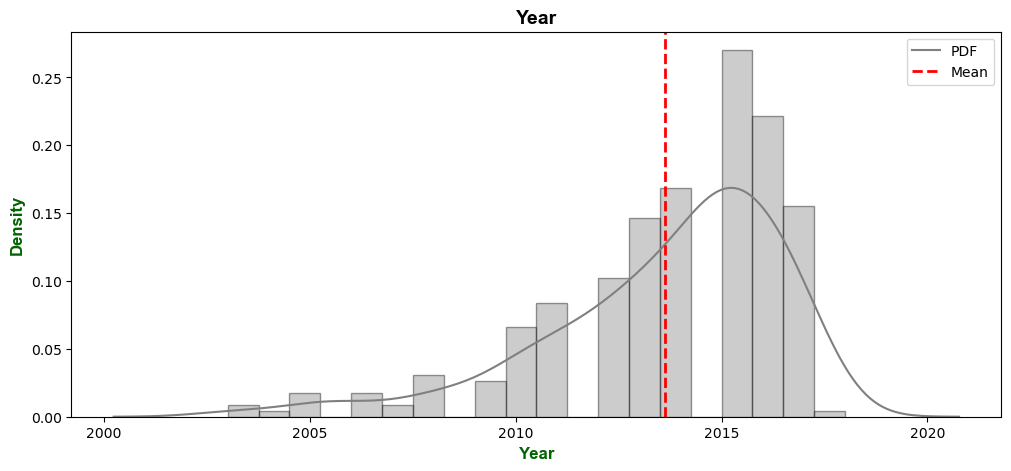

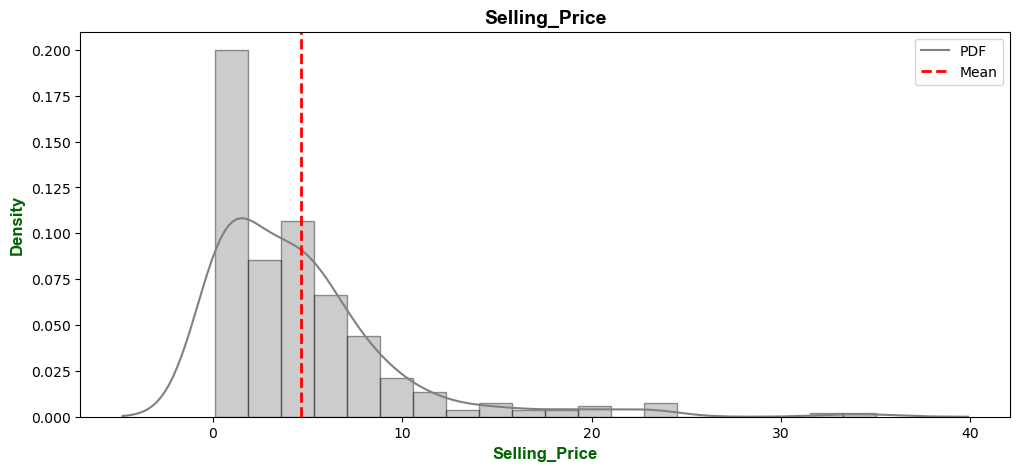

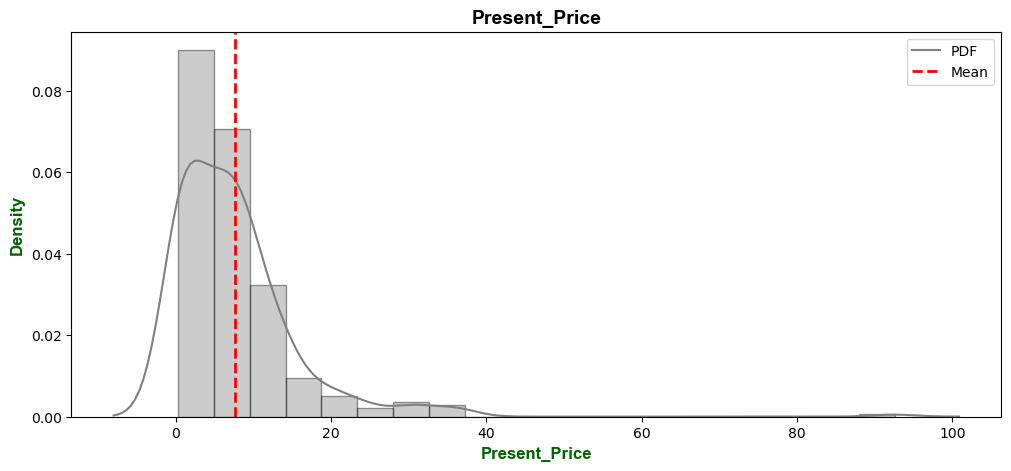

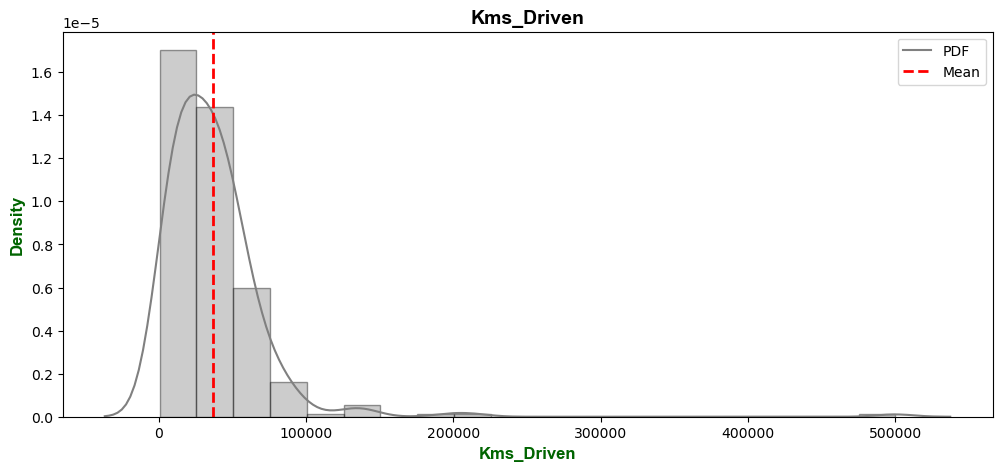

In [196]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "darkgreen", "weight" : "bold", "size" : 12}

for field in num_f:
    
    fig, ax = plt.subplots(figsize = (12, 5))
    
    sns.distplot(df[field], kde = True, bins = 20, color = "gray", hist_kws = dict(linewidth = 1, edgecolor = "k"), ax = ax)
    ax.axvline(df[field].mean(), color = "r", ls = "--", lw = 2)
    
    ax.legend(["PDF", "Mean"])
    
    plt.title(field, fontdict = title_font)
    plt.xlabel(field, fontdict = axes_font)
    plt.ylabel("Density", fontdict = axes_font)

### Examining Statistics of Categorical Fields

In [197]:
unique_values_df = pd.DataFrame(columns = ["Field_Name", "Unique_Values"])

fields_list = []
unique_values_list = []

for field in cat_f:

    fields_list += [field]
    field_unique_values_list = list(df[field].unique())
        
    unique_values_str = ""
        
    for values_str in field_unique_values_list:
        if field_unique_values_list.index(values_str) != len(field_unique_values_list) - 1:
            unique_values_str += str(values_str) + " | "
        else:
            unique_values_str += str(values_str)                 
        
    unique_values_list += [unique_values_str]
    
unique_values_df["Field_Name"] = fields_list
unique_values_df["Unique_Values"] = unique_values_list
    
unique_values_df

,Field_Name,Unique_Values
0,Fuel_Type,Petrol | Diesel | CNG
1,Seller_Type,Dealer | Individual
2,Transmission,Manual | Automatic
3,Owner,0 | 1 | 3


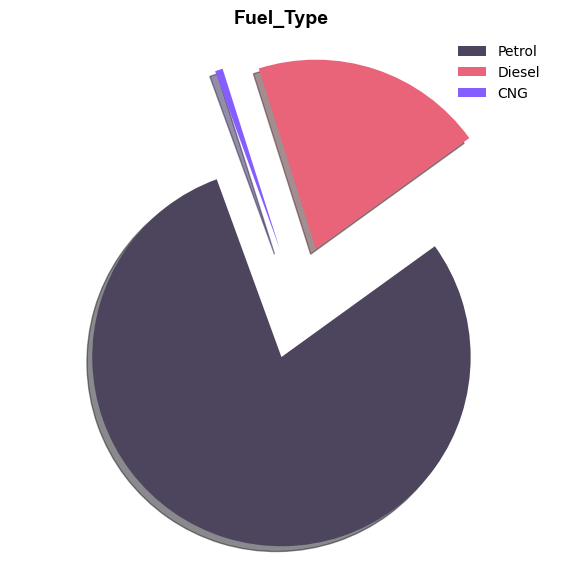

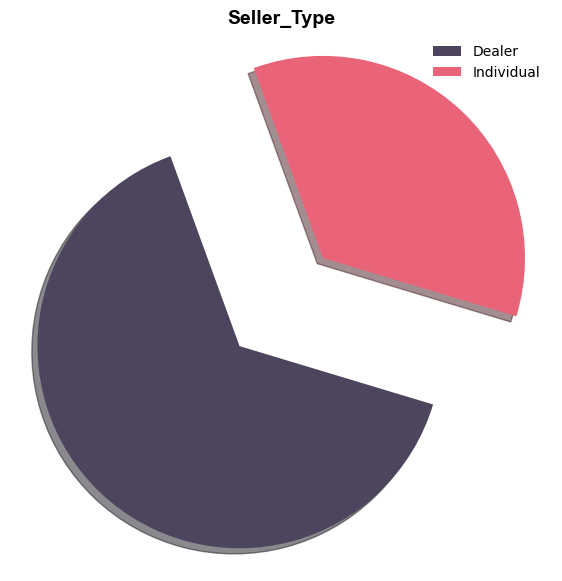

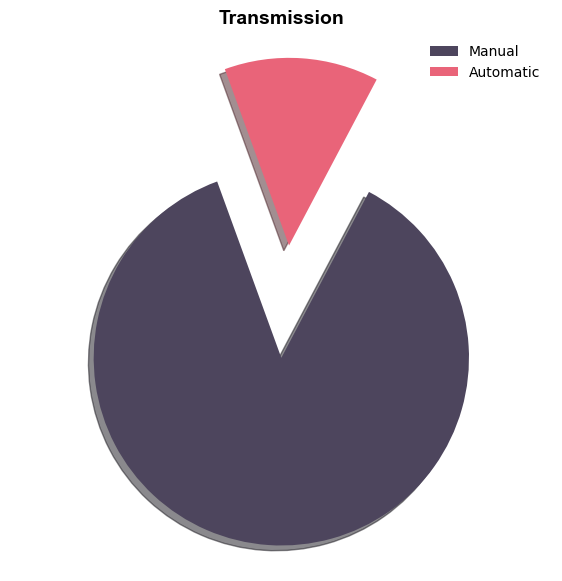

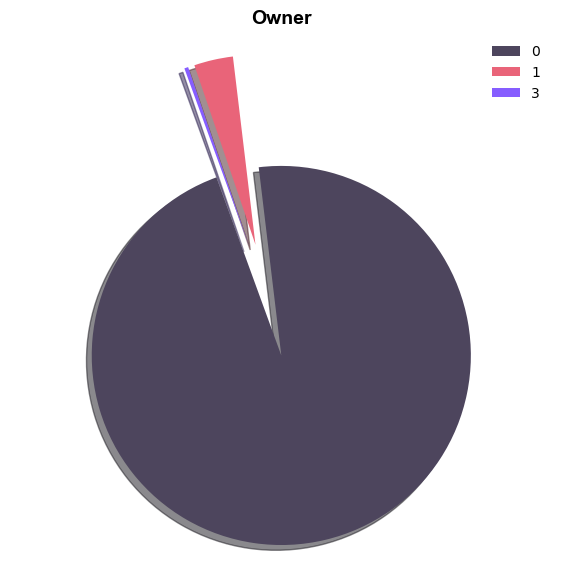

In [198]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
text_font = {"family" : "arial", "color" : "k", "size" : 10}

colors = ["#4D455D", "#E96479", "#865DFF"]
explode = (0.3,)

for field in cat_f:
        
    fig, ax = plt.subplots(figsize = (7, 7))
    field_unique_values_list = list(df[field].unique())
    
    ax.pie((np.array(df[field].value_counts())), 
            labeldistance = 100, startangle = 110, colors = colors, shadow = True,
            explode = explode * len(np.array(df[field].value_counts())))
    
    ax.axis("equal")
    ax.legend(field_unique_values_list, loc = "upper right", frameon = False)
    
    plt.title(field, fontdict = title_font)

[Project Content](#0)

## 8. Adding an Integer Field for Each Categorical Field <a id = 8></a> 

In [206]:
cat_dict = {}

for field in cat_f[:-1]:
    
    cat_dict[field + "_str"] = list(df[field].unique())
    
    cat_dict[field + "_int"] = [i for i in range(1, len(list(df[field].unique())) + 1)]
    
cat_dict

{'Fuel_Type_str': ['Petrol', 'Diesel', 'CNG'],
 'Fuel_Type_int': [1, 2, 3],
 'Seller_Type_str': ['Dealer', 'Individual'],
 'Seller_Type_int': [1, 2],
 'Transmission_str': ['Manual', 'Automatic'],
 'Transmission_int': [1, 2]}

In [208]:
for field in cat_f[:-1]:
    
    df[field + "_int"] = df[field]
    df[field + "_int"].replace(cat_dict[field + "_str"], cat_dict[field + "_int"], inplace = True)
    
df

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Fuel_Type_int,Seller_Type_int,Transmission_int
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,1,1,1
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,2,1,1
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,1,1,1
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,1,1,1
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0,2,1,1
297,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0,1,1,1
298,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0,1,1,1
299,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0,2,1,1


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              301 non-null    int64  
 1   Selling_Price     301 non-null    float64
 2   Present_Price     301 non-null    float64
 3   Kms_Driven        301 non-null    int64  
 4   Fuel_Type         301 non-null    object 
 5   Seller_Type       301 non-null    object 
 6   Transmission      301 non-null    object 
 7   Owner             301 non-null    int64  
 8   Fuel_Type_int     301 non-null    int64  
 9   Seller_Type_int   301 non-null    int64  
 10  Transmission_int  301 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 26.0+ KB


In [214]:
cat_f_int = [i + "_int" for i in cat_f[:-1]] + [cat_f[-1]]

cat_f_int

['Fuel_Type_int', 'Seller_Type_int', 'Transmission_int', 'Owner']

[Project Content](#0)

## 8. Correlation Analysis <a id = 8></a> 

### Analysis between Numeric Fields Among Themselves

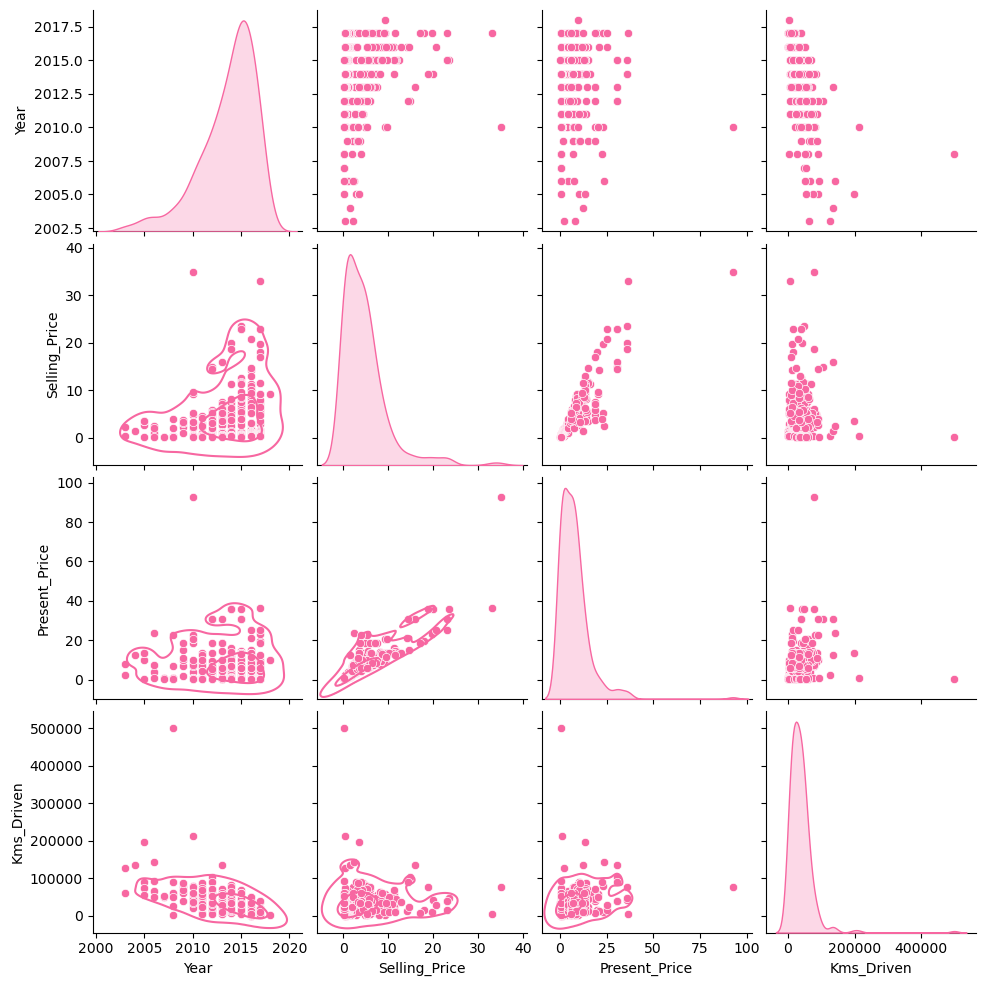

In [200]:
sns.set_palette("RdPu", 1)

graph = sns.pairplot(df[num_f], diag_kind = "kde")
graph.map_lower(sns.kdeplot, levels = 3, col = ".6")

plt.show()

In [201]:
df[num_f].corr()[["Year", "Present_Price", "Kms_Driven"]]

,Year,Present_Price,Kms_Driven
Year,1.000000,-0.047584,-0.524342
Selling_Price,0.236141,0.878983,0.029187
Present_Price,-0.047584,1.000000,0.203647
Kms_Driven,-0.524342,0.203647,1.000000


### Correlation Analysis between Numeric Fields and Target

In [233]:
((df[num_f].corr()[["Selling_Price"]]).T)[["Year", "Present_Price", "Kms_Driven"]]

,Year,Present_Price,Kms_Driven
Selling_Price,0.236141,0.878983,0.029187


### Correlation Analysis between Categorical Among Themselves

In [216]:
df[cat_f_int].corr()

,Fuel_Type_int,Seller_Type_int,Transmission_int,Owner
Fuel_Type_int,1.000000,-0.352415,0.080466,-0.055705
Seller_Type_int,-0.352415,1.000000,-0.063240,0.124269
Transmission_int,0.080466,-0.063240,1.000000,0.050316
Owner,-0.055705,0.124269,0.050316,1.000000


### Correlation Analysis between Categorical Fields and Target

In [228]:
((df[cat_f_int + ["Selling_Price"]].corr()[["Selling_Price"]]).T)[cat_f_int]

,Fuel_Type_int,Seller_Type_int,Transmission_int,Owner
Selling_Price,0.509467,-0.550724,0.367128,-0.088344


### Numeric and Categorical Fields Correlation Analysis

In [237]:
((df[cat_f_int + num_f].corr()[num_f]).T)[cat_f_int]

,Fuel_Type_int,Seller_Type_int,Transmission_int,Owner
Year,0.053643,-0.039896,-0.000394,-0.182104
Selling_Price,0.509467,-0.550724,0.367128,-0.088344
Present_Price,0.440415,-0.512030,0.348715,0.008057
Kms_Driven,0.166801,-0.101419,0.162510,0.089216


### Dropping Columns with Low Correlation

[Project Content](#0)

## 9. Dealing with Outliers <a id = 9></a> 

[Project Content](#0)

### 12. Determining Distributions of Numeric Fields <a id = 12></a> 

[Project Content](#0)

### 13. Appllying One Hot Encoding to Categorical Fields <a id = 13></a> 

[Project Content](#0)

### 14. Feature Scaling with The RobustScaler Method <a id = 14></a> 

[Project Content](#0)

### 15. Seperating Data into Two Parts of Train and Test <a id = 15></a> 

[Project Content](#0)

### 16. Modelling (Logistic Regression) <a id = 16></a> 

### 17. Cross Validation (Logistic Regression) <a id = 17></a> 

### 18. AUC-ROC Curve (Logistic Regression) <a id = 18></a> 

### 19. Hyper Parameter Optimization (Logistic Regression) <a id = 19></a> 

### 20. Modelling (Desicion Tree) <a id = 20></a> 

### 21. Cross Validation (Desicion Tree) <a id = 21></a> 

### 22. AUC-ROC Curve (Desicion Tree) <a id = 22></a> 

### 23. Hyper Parameter Optimization (Desicion Tree) <a id = 23></a> 

### 24. Modelling (Support Vector Classification) <a id = 24></a> 

### 25. Cross Validation (Support Vector Classification) <a id = 25></a> 

### 26. AUC-ROC Curve (Support Vector Classification) <a id = 26></a> 

### 27. Hyper Parameter Optimization (Support Vector Classification) <a id = 27></a> 

### 28. Modelling (Random Forest Classification) <a id = 28></a> 

### 29. Cross Validation (Random Forest Classification) <a id = 29></a> 

### 30. AUC-ROC Curve (Random Forest Classification) <a id = 30></a> 

### 31. Hyper Parameter Optimization (Random Forest Classification) <a id = 31></a> 